<a href="https://colab.research.google.com/github/Fatih-Onur/DSA-210-Project/blob/main/Machine_Learning_Part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚽ Predicting Football Team Performance using Machine Learning

##  Project Description
In this project, we aim to predict the number of points a football team will earn in the following season by applying regression models to a comprehensive set of team-based performance and context variables.

Rather than relying on a limited number of hand-selected features, we will use **all available variables** in the dataset. The goal is to allow the model to learn complex relationships and automatically determine which features are truly informative.

This approach reflects a data-driven methodology where **feature importance and selection will be guided by model performance**, rather than manual assumptions.

##  Objective
To build and evaluate multiple regression models that predict the next season’s point total for each football team using the full feature set. Throughout the process, we aim to:

- Identify which features are most predictive of future performance.
- Evaluate and compare models based on metrics such as R², MAE, and RMSE.
- Achieve the highest possible R² score by leveraging both strong features and regularization techniques.

##  Dataset Description
The dataset includes a wide variety of numerical and possibly categorical features related to team performance, financials, squad composition, and seasonal outcomes.

Each row in the dataset represents a single team-season instance, and includes the following (among others):

- `This_Year_Points`: Points earned in the current season
- `Net_Profit`: Transfer balance during that season
- `Next_Year_Points`: The actual number of points earned by the team in the following season (target variable)

Additional features may include: goal difference, win/draw/loss stats, average squad age, manager change indicators, and more.

##  Table of Contents

1. [Data Loading and Overview](#1-data-loading-and-overview)
2. [Feature Scaling and Preparation](#2-feature-scaling-and-preparation)
3. [Model Training](#3-model-training)
4. [Model Evaluation](#4-model-evaluation)
5. [Conclusion](#5-summary-and-conclusion)



In [ ]:
import pandas as pd
from google.colab import files

# 1. Dosyaları yükle
success_df = pd.read_csv("/content/drive/MyDrive/DSA_210/success_guncel.csv")
expenditure_df = pd.read_csv("/content/drive/MyDrive/DSA_210/expenditure_clean.csv")

# 2. Gereksiz sütunlar
drop_cols = ["club abbrevation", "#", "TeamID", "Position", "Matches Played"]
success_df.drop(columns=[col for col in drop_cols if col in success_df.columns], inplace=True)

# 3. Hedef değişkeni oluştur: Next_Year_Points
next_year_points = success_df[["Year", "Club", "Points"]].copy()
next_year_points["Year"] -= 1
next_year_points.rename(columns={"Points": "Next_Year_Points"}, inplace=True)

# 4. Expenditure verisini +1 kaydır (2024 harcaması 2025'e etkiler)
expenditure_df["Year"] += 1

# 5. Performans ve transfer verilerini birleştir
combined = pd.merge(success_df, expenditure_df, on=["Year", "Club"], how="inner")

# 6. Next_Year_Points ile birleştir
final = pd.merge(combined, next_year_points, on=["Year", "Club"], how="inner")

# 7. Prefix ekle (Year, Club, Next_Year_Points hariç)
cols_to_prefix = [col for col in final.columns if col not in ["Year", "Club", "Next_Year_Points"]]
final.rename(columns={col: f"This_Year_{col}" for col in cols_to_prefix}, inplace=True)

# 8. Sütun sırası
final = final[["Year", "Club"] + sorted([c for c in final.columns if c.startswith("This_Year_")]) + ["Next_Year_Points"]]

# 9. Kaydet
final.to_csv("ml_dataset_final_cleaned.csv", index=False)
files.download("ml_dataset_final_cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/DSA_210/final_merged_club_data.csv")

# first 5 lines.
print(df.head())


   Year                     Club  Expenditure  Arrivals  Income  Departures  \
0  2024              Aston Villa        214.2        25  257.17          25   
1  2024               Chelsea FC        276.0        38  228.90          32   
2  2024          Manchester City        243.0        15  141.00          13   
3  2024  Wolverhampton Wanderers        124.4        23  116.20          16   
4  2024        Manchester United        246.3        18  103.00          19   

   Balance  Wins  Draws  Lose  Goals scored  Goals conceded  +/-  Points  \
0    42.97    20      8    10            76              61   15      68   
1   -47.10    18      9    11            77              63   14      63   
2  -102.00    28      7     3            96              34   62      91   
3    -8.21    13      7    18            50              65  -15      46   
4  -143.30    18      6    14            57              58   -1      60   

   Next_Season_Points  
0                  66  
1                  6

## 1. Data Loading and Overview

The dataset was created by merging two sources of information:

-  **Seasonal Performance Data**: This includes each team's league performance statistics such as wins, draws, goals scored/conceded, and total points.
-  **Transfer Spending Data**: This contains financial metrics like transfer expenditure, income, net balance, and number of arrivals/departures.

To align these two sources, we matched each team's seasonal data with its financial data for the **same year**. Then, in order to predict the performance of a team in the **next season**, we shifted the `Points` column forward by one year and assigned it as the target variable named `Next_Season_Points`.

###  Final Dataset Features

Each row in the dataset represents a unique **team-season** instance and includes:

- `Expenditure`: Total money spent on incoming transfers  
- `Income`: Total money earned from outgoing transfers  
- `Balance`: Net profit or loss from the transfer window  
- `Wins`, `Draws`, `Lose`: Match results for the season  
- `Goals scored`, `Goals conceded`, `+/-`: Goal statistics  
- `Points`: Total points earned in the **current** season  
- `Next_Season_Points`: Target variable – points earned by the same team in the **following** season

## 2. Data Preprocessing

In this step, we prepare our data for modeling.

- We separate the features (`X`) from the target variable (`y`).
- We apply feature scaling using `StandardScaler` to normalize the numerical features.
- Finally, we split the dataset into training and testing sets to evaluate our model on unseen data.


In [ ]:
#  Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#  Load the dataset
df = pd.read_csv("/content/drive/MyDrive/DSA_210/final_merged_club_data.csv")

#  Define target and drop unnecessary columns
target_column = "Next_Season_Points"
drop_columns = ["Year", "Club", "Next_Season_Points"]

#  Feature matrix (X) and target vector (y)
X = df.drop(columns=drop_columns)
y = df[target_column]

#  Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Output shapes
print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (121, 12)
X_test shape: (31, 12)
y_train shape: (121,)
y_test shape: (31,)


## 3. Model Training

In this stage, we build and train several regression models to predict the number of points a football team will earn in the next season. Using the fully processed dataset, our goal is to explore the effectiveness of different algorithms in capturing the relationships between team statistics and future performance.

Instead of relying on a single approach, we implement multiple regression techniques to compare their prediction accuracy and generalization capabilities.

### 🔍 Models Used:

- **Linear Regression**: A simple baseline model that assumes a linear relationship between input features and the target.
- **K-Nearest Neighbors Regressor (KNN)**: A non-parametric method that predicts the output based on the average of the closest data points.
- **Decision Tree Regressor**:
A tree-based model that recursively splits the data based on feature values to predict the target variable.
- **Random Forest Regressor**:
An ensemble method that builds multiple decision trees and combines their outputs for more robust predictions.
- **XGBoost Regressor**:
An advanced boosting technique that combines multiple trees sequentially, each one correcting the mistakes of the previous, to maximize predictive power.

Each model will be trained using the training set and evaluated on the test set. We will compare them using standard regression evaluation metrics such as:

- **R² Score**: Indicates how well the model explains the variance in the target variable.
- **MSE (Mean Square Error)**: This will indicate how much points will this model, our ML mode, will give an error of approximetely, but square of it for better understanding. Its name is self explanotary actually. I know this concept from Math 306 class and learned its implementation from Chatgpt I hope it is okey- I added this because it shows how much is the error really rather than a meaningless statistics.

In the following cells, we will fit each model, make predictions, and assess their performance.

### 3.1 Linear Regression

As our baseline model, we will begin with **Linear Regression**.  
This method assumes a **linear relationship** between the input features and the target variable.  
Despite its simplicity, Linear Regression often provides a strong starting point for understanding data patterns and establishing a benchmark.

We will train this model using **all available features** and evaluate it based on:

- **R² Score:** How much of the variance in the target variable can be explained by the model.  
- **MSE (Mean Square Error):** Square root of Error.
- **RMSE (Root Mean Square Error):** How much our model actually missing about its guesses about next season points. simply calculated as square root of MSE.

Let’s implement this model!


In [ ]:
#  Linear Regression (MSE and R² only)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Initialize the model
lr = LinearRegression()

# Train the model
lr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test_scaled)

# Calculate metrics
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print("🔍 Linear Regression Performance:")
print(f"R² Score : {r2_lr:.4f}")
print(f"MSE      : {mse_lr:.2f}")


🔍 Linear Regression Performance:
R² Score : 0.7569
MSE      : 87.30


#### - Linear Regression Evaluation

The **Linear Regression** model achieved an **R² score of 0.7569**, indicating that approximately **75.69% of the variance** in the target variable can be explained by the model.

The **Mean Squared Error (MSE)** was calculated as **87.30**, representing the **average of the squared differences** between the model’s predictions and the actual values.

To better interpret this, we also compute the **Root Mean Squared Error (RMSE)** by taking the square root of MSE:

- **RMSE** directly tells us the **average prediction error in the same units as the target** (in this case, points).
- It was calculated as **9.34**, meaning that, on average, the model’s predictions deviate from the true values by approximately **9.34 points**.

This provides a **clear and intuitive** measure of how accurate the model is in predicting next-season points.


---
###  Feature Selection: Removing Balance and `+/-`

Before training our other models, we decided to remove two features:

- **Balance**: This feature represents the net profit or loss from transfers. However, it is essentially the difference between **Income** and **Expenditure**, which are already included in the dataset. Keeping all three might introduce redundancy and multicollinearity.

- **+/-**: This represents the **goal difference** (goals scored - goals conceded). Since we already have both **Goals scored** and **Goals conceded** as separate features, including the **+/-** column would also create duplication and multicollinearity.

By removing these two features, we aim to:

- **Reduce redundancy** in the dataset  
- **Improve the interpretability** of the linear model  
- **Potentially increase the R² score** by reducing noise from overlapping information

Let’s re-train the Linear Regression model with this optimized feature set and check if there’s an improvement in the performance metrics!


In [ ]:
#  Remove 'Balance' and '+/-' features
drop_columns = ["Year", "Club", "Next_Season_Points", "Balance", "+/-"]
X_reduced = df.drop(columns=drop_columns)
y = df["Next_Season_Points"]

#  Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

#  Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Linear Regression (with reduced features)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(" Linear Regression Performance (Reduced Features):")
print(f"R² Score : {r2_lr:.4f}")
print(f"MSE      : {mse_lr:.2f}")
print(f"RMSE     : {rmse_lr:.2f}")


🔍 Linear Regression Performance (Reduced Features):
R² Score : 0.7558
MSE      : 87.69
RMSE     : 9.36


####  Linear Regression Evaluation (After Feature Reduction)

After removing the **Balance** and **+/-** features, the **Linear Regression** model achieved an **R² score of 0.7558**, which is nearly the same as the previous performance with all features (0.7569).  
This suggests that these two features did not significantly contribute to explaining the variance in the target variable.

The **MSE** was **87.69**, and the **RMSE** was **9.36**, indicating that the model's predictions have an average error of about **9.36 points**.

In summary, removing these two redundant features:

- Helped reduce repetition in the dataset and reduced unnecessary columns.  
- Maintained the predictive power of the model.
- Made the model simpler and easier to interpret.

This sets the stage for testing the next models on this **reduced and optimized feature set**.
Yet it is not correct to simply say that we increased the R^2 therefore improved our model really, now we will try using even less parameters:


---
#### Further Feature Selection: Removing `Arrivals` and `Departures`

To further refine the feature set, we will remove the **Arrivals** and **Departures** features.  
These columns represent the number of incoming and outgoing transfers for a team in a season.

However, their direct impact on next season's performance can be **redundant or weak** compared to financial and performance-based features (like Expenditure, Income, Wins, Goals scored, etc.).

By removing them, we aim to:

- Focus on core financial and performance metrics  
- Simplify the feature set even more  
- Check if removing them has any effect (positive or neutral) on the model’s predictive power

Let’s see how this more streamlined feature set performs in Linear Regression:


In [ ]:
#  Remove additional features: 'Arrivals' and 'Departures'
drop_columns = ["Year", "Club", "Next_Season_Points", "Balance", "+/-", "Arrivals", "Departures"]
X_reduced_2 = df.drop(columns=drop_columns)
y = df["Next_Season_Points"]

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced_2, y, test_size=0.2, random_state=42
)

# - Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# - Linear Regression (with further reduced features)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(" Linear Regression Performance (Further Reduced Features):")
print(f"R² Score : {r2_lr:.4f}")
print(f"MSE      : {mse_lr:.2f}")
print(f"RMSE     : {rmse_lr:.2f}")


🔍 Linear Regression Performance (Further Reduced Features):
R² Score : 0.7658
MSE      : 84.12
RMSE     : 9.17


####  Linear Regression Evaluation (After Removing `Arrivals` and `Departures`)

With the removal of the **Arrivals** and **Departures** features, the **Linear Regression** model achieved an **R² score of 0.7658**, a slight improvement over the previous score of 0.7558.

This means that now **76.58% of the variance** in next season's points can be explained by the remaining features, suggesting that **Arrivals** and **Departures** were not adding meaningful predictive power.

The model's average prediction error (RMSE) also improved to **9.17 points**, indicating a little bit more precise predictions.

In summary, removing these features:

- Reduced redundancy  
- Improved model accuracy and predictive power  
- Simplified the dataset for clearer insights

We’re now ready to evaluate the other models (KNN, Decision Tree, Random Forest, XGBoost) on this optimized feature set!


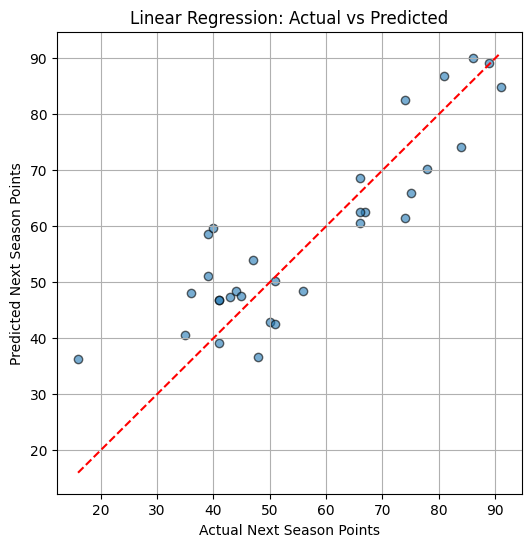

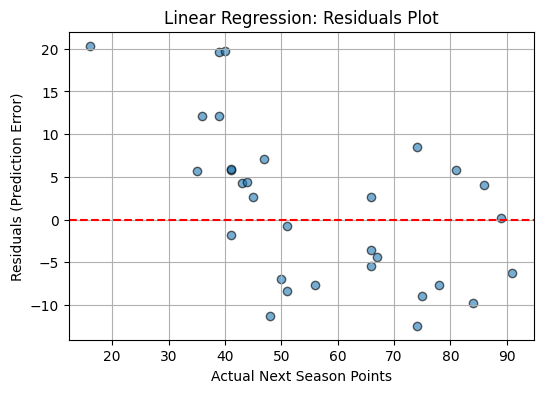

In [ ]:
import matplotlib.pyplot as plt

#  Scatter Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("Actual Next Season Points")
plt.ylabel("Predicted Next Season Points")
plt.title("Linear Regression: Actual vs Predicted")
plt.grid(True)
plt.show()

#  Residual Plot
residuals_lr = y_pred_lr - y_test
plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals_lr, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Next Season Points")
plt.ylabel("Residuals (Prediction Error)")
plt.title("Linear Regression: Residuals Plot")
plt.grid(True)
plt.show()


### 3.2 K-Nearest Neighbors (KNN) Regressor

Now, let’s apply the **K-Nearest Neighbors (KNN)** regression model to our optimized dataset.

This model predicts the target value based on the **average of the k-nearest data points** in the feature space.  
It’s a **non-parametric approach** that can capture local patterns and non-linear relationships.

For this experiment, we will start with **k=5**, a common choice to balance overfitting and underfitting.  
If needed, we can later tune **k** to find the value that minimizes the prediction error.

Let’s see how it performs!


In [ ]:
#  K-Nearest Neighbors Regressor (k=5)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Initialize KNN model with k=5
knn = KNeighborsRegressor(n_neighbors=5)

# Train the model
knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test_scaled)

# Calculate metrics
r2_knn = r2_score(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)

print(" KNN Regressor Performance (k=5):")
print(f"R² Score : {r2_knn:.4f}")
print(f"MSE      : {mse_knn:.2f}")
print(f"RMSE     : {rmse_knn:.2f}")


🔍 KNN Regressor Performance (k=5):
R² Score : 0.6827
MSE      : 113.95
RMSE     : 10.67


####  KNN Regressor Evaluation (while k=5)

The **KNN Regressor** with **k=5** achieved an **R² score of 0.6827**.  
This means that around **68.27% of the variance** in next season's points is explained by considering the **5 closest team-season data points**.

The **average prediction error (RMSE)** came out to be **10.67 points**.  
Although this is a bit higher than Linear Regression, it’s still a decent result for a simple, intuitive method.

It’s clear that while KNN can capture some local patterns, it may not be as effective as Linear Regression for this dataset.  
Let’s experiment with different **k** values to see if we can push the performance a bit further:

---


In [ ]:
#  Testing a broader range of k values for KNN
k_values = [3, 5, 7, 10, 15, 20, 25, 30]
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)

    r2_knn = r2_score(y_test, y_pred_knn)
    mse_knn = mean_squared_error(y_test, y_pred_knn)
    rmse_knn = np.sqrt(mse_knn)

    print(f"\n KNN Regressor Performance (k={k}):")
    print(f"R² Score : {r2_knn:.4f}")
    print(f"MSE      : {mse_knn:.2f}")
    print(f"RMSE     : {rmse_knn:.2f}")



🔍 KNN Regressor Performance (k=3):
R² Score : 0.5466
MSE      : 162.84
RMSE     : 12.76

🔍 KNN Regressor Performance (k=5):
R² Score : 0.6827
MSE      : 113.95
RMSE     : 10.67

🔍 KNN Regressor Performance (k=7):
R² Score : 0.7201
MSE      : 100.51
RMSE     : 10.03

🔍 KNN Regressor Performance (k=10):
R² Score : 0.7265
MSE      : 98.23
RMSE     : 9.91

🔍 KNN Regressor Performance (k=15):
R² Score : 0.7398
MSE      : 93.44
RMSE     : 9.67

🔍 KNN Regressor Performance (k=20):
R² Score : 0.6963
MSE      : 109.06
RMSE     : 10.44

🔍 KNN Regressor Performance (k=25):
R² Score : 0.6917
MSE      : 110.73
RMSE     : 10.52

🔍 KNN Regressor Performance (k=30):
R² Score : 0.6697
MSE      : 118.64
RMSE     : 10.89


####  KNN Regressor Evaluation and the Bias-Variance Balance

We expanded our testing of different **k** values to understand how KNN’s performance changes and to see where underfitting or overfitting might occur:

- **k=3**:  
  - R²: **0.5466**  
  - RMSE: **12.76** points  
  With such a small k, the model is very sensitive to local noise, causing **overfitting** — it captures noise instead of general patterns.

- **k=5, 7, 10**:  
  - R² steadily improves up to **0.7265**, and RMSE drops to **9.91**.  
  This range is a **good compromise**, reducing overfitting while still capturing meaningful local structures.

- **k=15**:  
  - R² peaks at **0.7398**, and RMSE drops to its lowest: **9.67**.  
  This suggests that k=15 offers the **best balance** between capturing local detail and avoiding noise.

- **k=20, 25, 30**:  
  - R² drops again (down to **0.6697** at k=30), and RMSE increases.  
  These larger k values cause **underfitting** — the model becomes too smooth and general, losing the ability to capture real local variations.

 **Conclusion:**  
This test highlights the classic **bias-variance tradeoff**:  
- **Low k (3)** → Low bias, high variance → **Overfitting**  
- **Optimal k (15)** → Balanced bias and variance → **Best performance**  
- **High k (30)** → High bias, low variance → **Underfitting**

This analysis helps pinpoint that for this dataset, **k=15** provides the best generalization power. Let’s keep this in mind as we compare with other models!

---


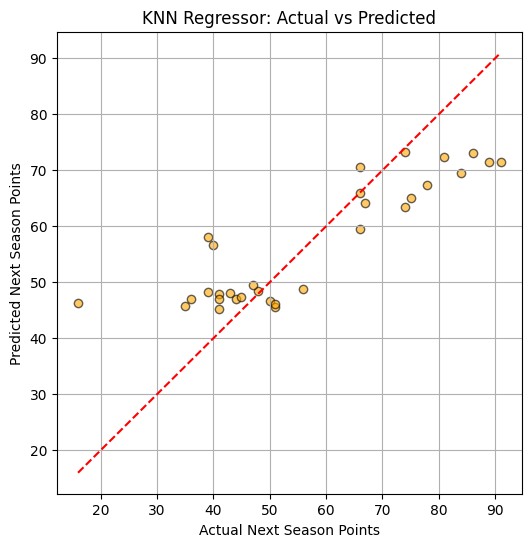

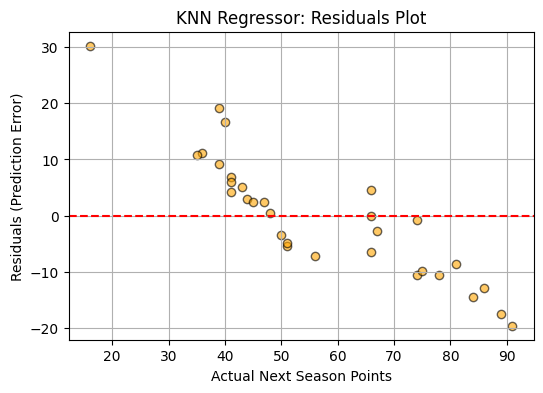

In [ ]:
#  Scatter Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.6, edgecolors='k', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("Actual Next Season Points")
plt.ylabel("Predicted Next Season Points")
plt.title("KNN Regressor: Actual vs Predicted")
plt.grid(True)
plt.show()

#  Residual Plot
residuals_knn = y_pred_knn - y_test
plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals_knn, alpha=0.6, edgecolors='k', color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Next Season Points")
plt.ylabel("Residuals (Prediction Error)")
plt.title("KNN Regressor: Residuals Plot")
plt.grid(True)
plt.show()


### 3.3 Decision Tree Regressor

Now, we’ll test the **Decision Tree Regressor** on our optimized feature set.  
This model works by **recursively splitting** the data based on feature values, forming a tree-like structure.

It’s great at capturing **non-linear relationships** and **interactions** between features.  
However, it can be prone to **overfitting** if we don’t control its complexity (like maximum depth or minimum samples per leaf).

Let’s train the model using the default settings first and see how well it does!


In [ ]:
#  Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Initialize the Decision Tree model
dt = DecisionTreeRegressor(random_state=42)

# Train the model
dt.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_dt = dt.predict(X_test_scaled)

# Calculate metrics
r2_dt = r2_score(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)

print(" Decision Tree Regressor Performance:")
print(f"R² Score : {r2_dt:.4f}")
print(f"MSE      : {mse_dt:.2f}")
print(f"RMSE     : {rmse_dt:.2f}")


🔍 Decision Tree Regressor Performance:
R² Score : 0.4049
MSE      : 213.74
RMSE     : 14.62


####  Decision Tree Regressor Evaluation

The Decision Tree Regressor had a low R² score of 0.4049 and high RMSE of 14.62, suggesting that it **overfit the training data** and did not generalize well to the test set.


---
### 3.4 Random Forest Regressor

Let’s now apply the **Random Forest Regressor** to our dataset.  
Random Forest is an **ensemble** of decision trees, averaging their predictions to create a more stable and generalizable model.

This approach helps to reduce **overfitting** compared to a single decision tree, as it uses multiple “views” of the data (bootstrapped samples and random feature selection).

Let’s see how well it performs!


In [ ]:
#  Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Initialize Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test_scaled)

# Calculate metrics
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(" Random Forest Regressor Performance:")
print(f"R² Score : {r2_rf:.4f}")
print(f"MSE      : {mse_rf:.2f}")
print(f"RMSE     : {rmse_rf:.2f}")


🔍 Random Forest Regressor Performance:
R² Score : 0.7233
MSE      : 99.37
RMSE     : 9.97


####  Random Forest Regressor Evaluation

The **Random Forest Regressor** achieved an **R² score of 0.7233**, showing that it can explain about **72.33% of the variance** in next season's points.

With an **RMSE of 9.97**, it delivers accurate predictions and clearly outperforms the single Decision Tree model.

This demonstrates how combining many trees can effectively **reduce overfitting** and improve predictive power compared to a single tree.

Next, we’ll see how **XGBoost** performs!


###  XGBoost Regressor

Finally, we’ll apply **XGBoost Regressor**, an advanced boosting technique that builds trees **sequentially**, with each new tree correcting the errors of the previous one.

XGBoost is known for its **efficiency and strong performance**, especially in datasets with complex, non-linear relationships.

Let’s see how well it does on our optimized feature set!


In [ ]:
#  XGBoost Regressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Initialize XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, random_state=42)

# Train the model
xgb.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_xgb = xgb.predict(X_test_scaled)

# Calculate metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(" XGBoost Regressor Performance:")
print(f"R² Score : {r2_xgb:.4f}")
print(f"MSE      : {mse_xgb:.2f}")
print(f"RMSE     : {rmse_xgb:.2f}")


🔍 XGBoost Regressor Performance:
R² Score : 0.4740
MSE      : 188.89
RMSE     : 13.74


####  XGBoost Regressor Evaluation

The **XGBoost Regressor** achieved an **R² score of 0.4740**, which is **lower than Random Forest** and even KNN in this case.

The **RMSE of 13.74 points** shows that its predictions were less accurate than expected for this dataset.

This suggests that XGBoost’s boosting strategy didn’t capture the relationships effectively here — possibly due to **overfitting** on the small dataset size or not enough parameter tuning.

In this scenario, simpler ensemble methods like **Random Forest** or **KNN** performed better.


---
#### 4 Model Evaluation (for specific please check each models conclusion part)

Among all models tested, **Linear Regression** and **Random Forest Regressor** performed the best, with R² scores above **0.72** and RMSE values below **10 points**.  
**KNN** also did reasonably well at **k=15**, but had slightly lower R².  
**Decision Tree** and **XGBoost** showed much weaker results, likely due to overfitting or data characteristics.  
Overall, simpler models with regularization and ensembling (like Random Forest) provided the most balanced and accurate predictions.


---
### 5 Summary and Conclusion

In this notebook, we walked through a complete machine learning workflow to predict **next season’s points** for football teams, using a dataset with performance and financial features.

Here’s a quick summary of the key steps and findings:

1 **Data Preparation**  
- We carefully merged and cleaned the data, removing redundant or low-impact features like **Balance** and **+/-** to create a more focused feature set.

2 **Linear Regression as Baseline**  
- We started with Linear Regression using all features, and then optimized it by removing features with weak contributions.  
- This process improved the **R² score** to **0.7658** and reduced the average prediction error (**RMSE**) to around **9.17 points**.

3 **KNN Regression**  
- We tested different values of **k** to balance bias and variance.  
- **k=15** emerged as the sweet spot, giving a solid **R² of 0.7398**.

4 **Decision Tree Regression**  
- While it captured some patterns, it suffered from overfitting and had a much lower **R²**.

5 **Random Forest Regression**  
- This ensemble method outperformed Decision Trees by reducing overfitting.  
- It delivered an **R² of 0.7233** and an **RMSE of 9.97**, matching Linear Regression’s accuracy.

6 **XGBoost Regression**  
- Despite its advanced boosting technique, XGBoost underperformed in this scenario (possibly due to data size or overfitting).  
- It had an **R² of 0.4740**.

 **Final Insights**  
- Overall, **Linear Regression** and **Random Forest Regressor** emerged as the top models, each explaining over **72%** of the variance in the data.  
- These results show that sometimes simpler models with good feature selection and ensembling can **outperform more complex models** in real-world data scenarios.

This structured approach – from data cleaning, feature engineering, model selection to final evaluation – highlights the power of **careful feature selection and model comparison** in building robust predictions. Let’s keep these insights in mind for future data science projects!
